# Out-of-Sample (OOS) Embedding

Suppose we've embedded the nodes of a graph into Euclidean space using Adjacency Spectral Embedding.  
Then, suppose we gain access to new nodes not seen in the original graph. We sometimes wish to determine their latent positions without the computationally-expensive task of re-embedding an entirely new adjacency matrix.

More formally, suppose we have computed the embedding $\hat{X} \in \textbf{R}^{n \times d}$ from some adjacency matrix $A \in \textbf{R}^{n \times n}$.  
Suppose we then obtain some new vertex $w \in \textbf{R}^n$ or new vertices $W \in \textbf{R}^{m \times n}$ and we want to know their latent positions.

We can obtain an estimation for these out-of-sample latent positions with ASE's `predict` method.  
Running through the Adjacency Spectral Embedding tutorial is recommended prior to this tutorial.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from numpy.random import normal, poisson

from graspologic.simulations import sbm
from graspologic.embed import AdjacencySpectralEmbed as ASE
from graspologic.plot import heatmap, pairplot
from graspologic.utils import remove_vertices

np.random.seed(9002)
import warnings
warnings.filterwarnings('ignore')

## Undirected out-of-sample prediction

Here, we embed an undirected two-block stochastic block model with ASE. We then use its predict method to find an out-of-sample prediction for both a single vertex and multiple vertices.  

We begin by generating data.

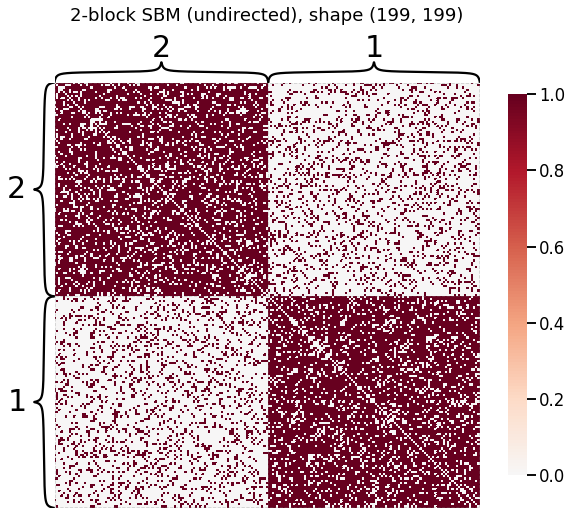

In [2]:
# Generate parameters
nodes_per_community = 100
labels = [1]*nodes_per_community + [2]*nodes_per_community
P = np.array([[0.8, 0.2],
              [0.2, 0.8]])

# Generate a directed and undirected Stochastic Block Model (SBM)
undirected = sbm(2*[nodes_per_community], P)

# Grab out-of-sample vertices
oos_idx = 0
oos_labels = labels.pop(oos_idx)
A, a = remove_vertices(undirected, indices=oos_idx, return_removed=True)

# plot our SBMs
heatmap(A, title=f'2-block SBM (undirected), shape {A.shape}', inner_hier_labels=labels);

### Embedding

We then generate an embedding with ASE, and we use its predict method to determine our best estimate for the latent position of the out-of-sample vertex.

In [3]:
# Generate an embedding with ASE
ase = ASE(n_components=2)
X_hat = ase.fit_transform(A)

# predicted latent positions
w = ase.transform(a)
w

array([0.71754581, 0.51499   ])

#### Plotting out-of-sample embedding

Here, we plot the original latent positions as well as the out-of-sample vertices. Note that the out-of-sample vertices are near their expected latent positions despite not having been run through the original embedding.

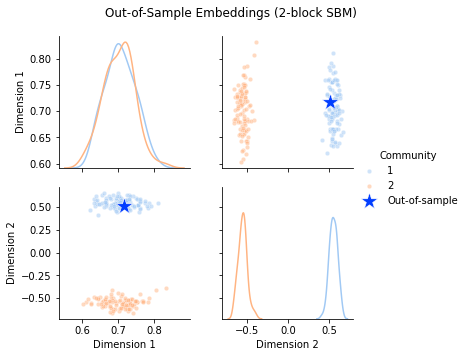

In [4]:
def plot_oos(X_hat, oos_vertices, n_verts, labels, oos_labels, title):
    # collect data
    d = {'Community': labels, 'Dimension 1': X_hat[:, 0], 'Dimension 2': X_hat[:, 1]}
    df = pd.DataFrame(data=d)
    unique_labels = list(df["Community"].unique())
    
    # add out-of-sample points to data
    oos_vertices = np.atleast_2d(oos_vertices)
    d = {'Community': oos_labels, 'Dimension 1': oos_vertices[:, 0], 'Dimension 2': oos_vertices[:, 1]}
    oos_df = pd.DataFrame(d)
    df = df.append(oos_df)

    # Create PairGrid plot for data
    is_len, oos_len = len(unique_labels), len(oos_labels)
    colors_is = sns.color_palette("pastel", n_colors=is_len)
    colors_oos = sns.color_palette("bright", n_colors=oos_len)
    kws = lambda a, b: [a for i in range(is_len)] + [b for i in range(oos_len)]
    g = sns.PairGrid(df, hue="Community",
                     hue_order=unique_labels + oos_labels,
                     palette=colors_is + colors_oos,
                     hue_kws={"s": kws(20, 300),
                              "marker": kws("o", "*"),
                              "alpha": kws(.5, 1),
                             },
                     layout_pad=1)

    # Add data to plot and change figure settings
    g.map_offdiag(plt.scatter, linewidth=.5, edgecolor="w")
    g.map_diag(sns.kdeplot);
    g.add_legend();
    plt.subplots_adjust(top=0.9);
    g.fig.suptitle(title);
    
plot_oos(X_hat, w, nodes_per_community, labels, oos_labels=["Out-of-sample"],
         title="Out-of-Sample Embeddings (2-block SBM)");

### Passing in multiple out-of-sample vertices

You can pass a 2d numpy array into `predict`. The rows are the out-of-sample vertices, and the columns are their edges to the in-sample vertices.

In [5]:
# Grab out-of-sample vertices
labels = [0]*nodes_per_community + [1]*nodes_per_community
oos_idx = [0, -1]
oos_labels = [labels.pop(i) for i in oos_idx]
A, a = remove_vertices(undirected, indices=oos_idx, return_removed=True)

# our out-of-sample array is m x n
print(f"a is {type(a)} with shape {a.shape}")

a is <class 'numpy.ndarray'> with shape (2, 198)


The out-of-sample prediction output has dimensions (2, 2)



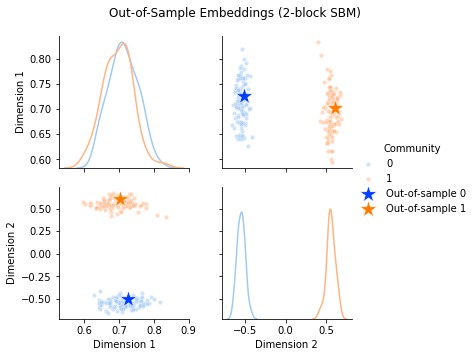

In [6]:
# Generate an embedding with ASE
ase = ASE(n_components=2)
X_hat = ase.fit_transform(A)

# predicted latent positions
w = ase.transform(a)
print(f"The out-of-sample prediction output has dimensions {w.shape}\n")

oos_labels = [f"Out-of-sample {i}" for i in range(len(oos_idx))]
plot_oos(X_hat, w, nodes_per_community, labels, oos_labels=oos_labels,
         title="Out-of-Sample Embeddings (2-block SBM)");

## Directed out-of-sample prediction

Not all graphs are undirected. When finding out-of-sample latent positions for directed graphs, $A \in \textbf{R}^{n \times n}$ is not symmetric. $A_{i,j}$ represents the edge from node $i$ to node $j$, whereas $A_{j, i}$ represents the edge from node $j$ to node $i$.

To account for this, we pass a tuple (left_oos, right_oos) into the predict method. It then outputs a tuple of (left_latent_prediction, right_latent_prediction).

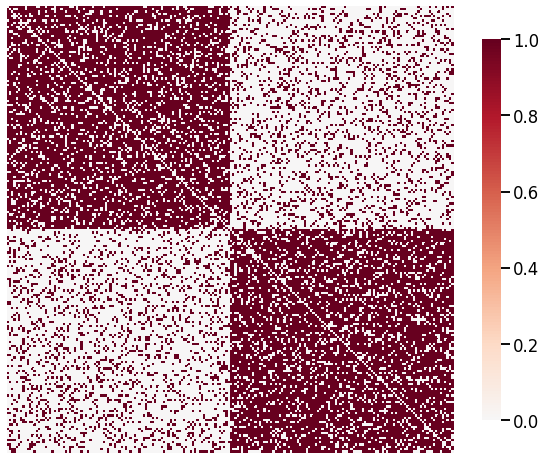

In [7]:
# a is a tuple of (oos_left, oos_right)
directed = sbm(2*[nodes_per_community], P, directed=True)
oos_idx = [0, -1]
A, a = remove_vertices(directed, indices=oos_idx, return_removed=True)
heatmap(directed);

In [8]:
# Fit a directed graph
X_hat, Y_hat = ase.fit_transform(A)

# predicted latent positions
w = ase.transform(a)
print(f"output of `ase.predict(a)` is {type(w)}", "\n")
print(f"left latent positions: \n{w[0]}\n")
print(f"right latent positions: \n{w[1]}")

ValueError: too many values to unpack (expected 2)

### Plotting directed latent predictions

In [ ]:
plot_oos(X_hat, w[0], nodes_per_community, labels, oos_labels=oos_labels, title="Left Latent Predictions")
plot_oos(Y_hat, w[1], nodes_per_community, labels, oos_labels=oos_labels, title="Right Latent Predictions")

## Weighted out-of-sample prediction

Weighted graphs work as well. Here, we generate a directed, weighted graph and estimate the latent positions for multiple out-of-sample vertices.

In [ ]:
# Generate a weighted graph and out-of-sample vertices
wt = [[normal, poisson],
      [poisson, normal]]
wtargs = [[dict(loc=3, scale=1), dict(lam=5)],
          [dict(lam=5), dict(loc=3, scale=1)]]
weighted = sbm(2*[nodes_per_community], P, wt=wt, wtargs=wtargs, directed=True)
oos_idx = [0, -1]
A, a = remove_vertices(weighted, indices=oos_idx, return_removed=True)
heatmap(A)

In [ ]:
# Embed and predict
X_hat, Y_hat = ase.fit_transform(A)
w = ase.transform(a)

# Plot
plot_oos(X_hat, w[0], nodes_per_community, labels, 
         oos_labels=oos_labels, title="Left Latent Predictions")
plot_oos(Y_hat, w[1], nodes_per_community, labels,
         oos_labels=oos_labels, title="Right Latent Predictions")